In [7]:
import requests
import os
from pprint import pprint
import json 
import pandas as pd 
from tqdm import tqdm
import time
import gzip
from GitHubAPI_retriever_v2 import extract_owner_repo_from_github_links

In [8]:
large_github_file = './data/cs.json.gz'
print(os.path.exists(large_github_file))

with gzip.open(large_github_file, 'rb') as f:
    d = json.loads(f.read().decode('utf-8'))

print(len(d))
pprint(list(d.items())[:2])

def extract_github_links(gzip_file):
    with gzip.open(gzip_file, 'rb') as f:
        d = json.loads(f.read().decode('utf-8'))
    github_urls = []
    for paper_id in d:
        github_links_list = d[paper_id]
        for metadata_github_link in github_links_list:
            github_urls.append(metadata_github_link['url'])
    return github_urls

urls = extract_github_links(large_github_file)
pprint(urls[:5])

owners, repos = extract_owner_repo_from_github_links(urls)
pprint(owners[:5])
pprint(repos[:5])

ppid, date_string, url = [], [], []
def extract_links_with_date(d):
    for _ppid in d:
        for each_url in d[_ppid]:
            # print(each_url)
            _date_string, _url = each_url['date'], each_url['url']
            ppid.append(_ppid)
            date_string.append(_date_string)
            url.append(_url)
    res_df = pd.DataFrame.from_dict({'ppid':ppid, 'date':date_string, 'url':url})
    res_df['date'] = pd.to_datetime(res_df['date'])
    return res_df

df = extract_links_with_date(d)
print(df.head())
print(len(df))
print(df.tail())

new_df = df['date'].groupby([df['date'].dt.year]).agg({'count'}).reset_index()
new_df.rename(columns={'date':'year'}, inplace=True)
print(new_df)

True
31455
[('1005.4552',
  [{'date': '2010-05-25',
    'source': 'regex',
    'url': 'http://github.com/JUrban/mwiki'}]),
 ('1005.4592',
  [{'date': '2010-05-25',
    'source': 'regex',
    'url': 'http://github.com/JUrban/MPTP2'}])]
['http://github.com/JUrban/mwiki',
 'http://github.com/JUrban/MPTP2',
 'http://github.com/pprett/bolt',
 'https://github.com/bmeurer/ocamljit2',
 'http://github.com/joshsh/laboratory']
['JUrban', 'JUrban', 'pprett', 'bmeurer', 'joshsh']
['mwiki', 'MPTP2', 'bolt', 'ocamljit2', 'laboratory']
        ppid       date                                   url
0  1005.4552 2010-05-25        http://github.com/JUrban/mwiki
1  1005.4592 2010-05-25        http://github.com/JUrban/MPTP2
2  1008.0716 2010-08-04         http://github.com/pprett/bolt
3  1011.1783 2010-11-08  https://github.com/bmeurer/ocamljit2
4  1011.3595 2010-11-16   http://github.com/joshsh/laboratory
45621
             ppid       date                                            url
45616  2007.16187 20

<AxesSubplot:xlabel='year', ylabel='count'>

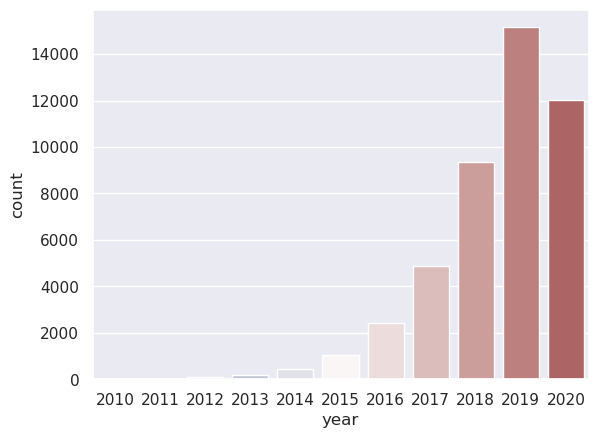

In [9]:
import seaborn as sns 
sns.set_theme(style='whitegrid')
sns.set(font_scale=1)
sns.set_color_codes('pastel')

sns.barplot(data=new_df, x='year', y='count',palette='vlag')

### Github Links statistics

In [13]:
def filter_distinct_e(d):
    # d is the dictionary read from the json.gz file
    unique_urls = {}    # unique_urls is a dictionary with keys being distinct urls and values being the indexes  
    
    for i, url in enumerate(tqdm(d['url'])):
        if url not in unique_urls:
            unique_urls[url] = [i]
        else:
            unique_urls[url].append(i)
    # produce the first appeared positions for all distinct urls
    first_pos = []
    for url in tqdm(unique_urls):
        first_pos.append(unique_urls[url][0])
    # produce the occurence count of each distinct url
    occur_count = {}
    for url in tqdm(unique_urls):
        occur_count[url] = len(unique_urls[url])
    return unique_urls, first_pos, occur_count

def read_gzip(filepath):
    try:
        output = {}
        output['paper_id'], output['source'], output['date'],output['url'] = [], [], [], []
        with gzip.open(filepath, 'rb') as f:
            res = json.loads(f.read().decode('utf-8'))
        for paper_id in tqdm(res):
            github_links_list = res[paper_id]
            for link in github_links_list:
                source_from, date, url = link['source'], link['date'], link['url']
                output['paper_id'].append(paper_id)
                output['source'].append(source_from)
                output['date'].append(date)
                output['url'].append(url)
        return output
    except OSError:
        print('')

res = read_gzip(large_github_file)
urls_dict, first_pos, occur_count = filter_distinct_e(res)
df_occur_count = pd.DataFrame.from_dict({'url':list(occur_count.keys()), 'count': list(occur_count.values())})

100%|██████████████████████| 32549/32549 [00:00<00:00, 3217013.48it/s]


In [19]:
def filter_repo_metadata(m, urls={}):
    # m is a dictionary of all retrieved repo metadata
    # still need to verify whether they contain the same schema
    # and remain only the distinct repos
    # repo_schema = ...
    # print('After filtering, '+ str(len(filtered_m)))
    filtered_m = m
    matched_urls = set()

    activity_record = {}
    activity_record['url'], activity_record['forks_count'], activity_record['watchers_count'], activity_record['subscribers_count'] = [], [], [], []
    for i in tqdm(filtered_m):
        # print(m[i].keys())
        # print(m[i]['html_url'])
        # print(m[i]['owner']['login'],m[i]['name'])
        # print(m[i]['forks_count'], m[i]['watchers_count'], m[i]['subscribers_count'])
        try:
            keys = filtered_m[i].keys()
            if 'html_url' not in keys:
                continue
            if 'forks_count' not in keys:
                continue
            if 'watchers_count' not in keys:
                continue
            if 'subscribers_count' not in keys:
                continue
            # if filtered_m[i]['html_url'] not in urls:
            #     continue
            if filtered_m[i]['html_url'] in matched_urls:
                    continue
            matched_urls.add(filtered_m[i]['html_url'])
            activity_record['url'].append(filtered_m[i]['html_url'])
            activity_record['forks_count'].append(filtered_m[i]['forks_count'])
            activity_record['watchers_count'].append(filtered_m[i]['watchers_count'])
            activity_record['subscribers_count'].append(filtered_m[i]['subscribers_count'])
        except AttributeError as ae:
            continue
        except TypeError as te:
            continue
        # pprint(activity_record)
    return filtered_m, activity_record

def read_repo_metadata(filepath):
    try:
        with gzip.open(filepath, 'r') as f:
            res = json.loads(f.read().decode('utf-8'))
        return res
    except OSError:
        print('')

json_filepath = './data/metadata.json.gz'
metadata = read_repo_metadata(json_filepath)
print(len(metadata))
print(len(first_pos))

filtered_metadata, act_rec = filter_repo_metadata(metadata, urls=urls_dict)
print(len(act_rec['url']), 
      len(act_rec['forks_count']), 
      len(act_rec['subscribers_count']),
      len(act_rec['watchers_count']))

print((act_rec['url'][1409]), 
      (act_rec['forks_count'][1409]), 
      (act_rec['subscribers_count'][1409]),
      (act_rec['watchers_count'][1409]))

print((act_rec['url'][1739]), 
      (act_rec['forks_count'][1739]), 
      (act_rec['subscribers_count'][1739]),
      (act_rec['watchers_count'][1739]))

urls_l1 = list(urls_dict.keys())
urls_l2 = act_rec['url']
for url in urls_l1:
    if 'AKSW' in url:
        print(url)
print('\n\n')
for url in urls_l2:
    if 'AKSW' in url:
        print(url)
print(len(urls_l1))
print(len(set(urls_l2)))
print(len(set(urls_l1) & set(urls_l2)))
print(len(list(set([e for e in urls_l2 if e not in urls_l1]))))
print(list(set([e for e in urls_l1 if e not in urls_l2])))


32117
32549


100%|███████████████████████| 32117/32117 [00:00<00:00, 470712.35it/s]

29300 29300 29300 29300
https://github.com/walid-shalaby/wikiextractor 1 1 0
https://github.com/SeSaMe-NUS/genie 16 25 81
https://github.com/AKSW/Sparqlify
https://github.com/AKSW/gerbil
https://github.com/AKSW/LSQ
https://github.com/AKSW/jena-sparql-api
http://github.com/AKSW/rocker
https://github.com/AKSW/AGDISTIS
https://github.com/AKSW/NLIWOD
https://github.com/AKSW/Mandolin
https://github.com/AKSW/SemWeb2NL
http://github.com/AKSW/KG2Vec
https://github.com/AKSW/NSpM
http://github.com/AKSW/RDFUnit
https://github.com/AKSW/RDFUnit
https://github.com/AKSW/Palmetto



https://github.com/AKSW/LSQ
https://github.com/AKSW/rocker
https://github.com/AKSW/Mandolin
https://github.com/AKSW/KG2Vec
https://github.com/AKSW/RDFUnit
32549
29300
25916


3384
['https://github.com/bmcfee/librosa', 'https://github.com/JuliaInv/jInv', 'https://github.com/mayee107/network-disruption', 'http://christophe-pouzat.github.io/LASCON2016/OriginOfTheHighFrequencyExtraCellularSignal', 'https://¦github.com/CPqD/ofsoftswitch13', 'https://github.com/itseez/opencv', 'http://rodrigonogueira4.github.io/BusData/Outlier_Vis', 'https://github.com/henriquem87/structured-graph-tracker', 'https://¦github.com/tensorflow/graphics', 'https://github.com/LUMII-Syslab/Switchblade', 'https://¦github.com/opendatateam/udata', 'https://gist.github.com/XVilka/8346728', 'https://github.com/LachlanGunn/Keywatch', 'https://github.com/microsoft/DiCE', 'https://github.com/MohammadSamragh/CodeX', 'https://github.com/UniversalDependencies/UDEstonian-EDT', 'https://github.com/zuohuif/ABSent', 'https://github.com/kylelutz/compute', 'http://github.com/lttam/PersistenceFisher', 'https://github.com/rsennrich/nematusWe', 'https://github.com/Microsoft/human-pose-estimation', 'https://

                                                     url  forks_count
22891   https://github.com/rdpeng/ProgrammingAssignment2       141755
13548  https://github.com/SmartThingsCommunity/SmartT...        91342
1928            https://github.com/tensorflow/tensorflow        87524
23667                  https://github.com/twbs/bootstrap        77622
3294                    https://github.com/opencv/opencv        53202
1376                https://github.com/tensorflow/models        46099
2435                   https://github.com/torvalds/linux        45792
14357                  https://github.com/facebook/react        41263
12859  https://github.com/spring-projects/spring-fram...        35140
26511           https://github.com/kubernetes/kubernetes        34574
                                                    url  subscribers_count
2435                  https://github.com/torvalds/linux               8101
1928           https://github.com/tensorflow/tensorflow               7796
14498

<AxesSubplot:xlabel='watchers_count', ylabel='url'>

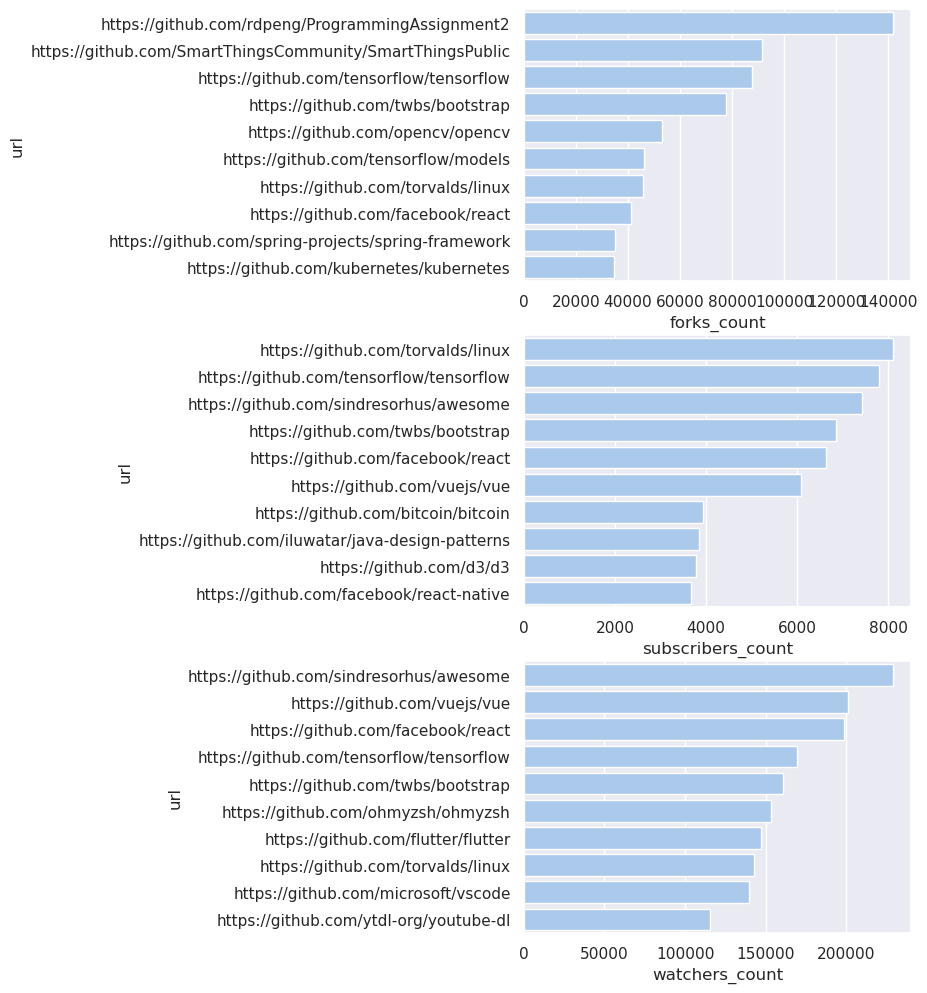

In [20]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.set(font_scale=1)
sns.set_color_codes('pastel')
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(5,12))



df_act_rec = pd.DataFrame.from_dict(act_rec)
forks_count = np.array(act_rec['forks_count'])
l1 = heapq.nlargest(10, range(len(forks_count)), forks_count.take)
print(df_act_rec[['url','forks_count']].iloc[l1])
df1 = df_act_rec[['url','forks_count']].iloc[l1]
sns.barplot(
    data=df1,x='forks_count', y='url',color='b',ax=ax1
)


subscribers_count = np.array(act_rec['subscribers_count'])
l2 = heapq.nlargest(10, range(len(subscribers_count)), subscribers_count.take)
print(df_act_rec[['url','subscribers_count']].iloc[l2])
# print(max(act_rec['subscribers_count']))
df2 = df_act_rec[['url','subscribers_count']].iloc[l2]

sns.barplot(
    data=df2,x='subscribers_count', y='url',color='b',ax=ax2
)

watchers_count = np.array(act_rec['watchers_count'])
l3 = heapq.nlargest(10, range(len(watchers_count)), watchers_count.take)
print(df_act_rec[['url','watchers_count']].iloc[l3])
# print(max(act_rec['watchers_count'])) 
df3 = df_act_rec[['url','watchers_count']].iloc[l3]

sns.barplot(
    data=df3,x='watchers_count', y='url',color='b',ax=ax3
)

In [21]:
## compute correlation matrix 
df_fork_subscribe = df_act_rec[['forks_count', 'subscribers_count','watchers_count']]
# print(df_fork_subscribe.head())
df_fork_subscribe.rename(columns = {'forks_count':'forks', 
                                    'subscribers_count':'subscribers',
                                    'watchers_count':'watchers',
                                   }, 
                         inplace = True)
df_fork_subscribe.corr()


/tmp/ipykernel_34847/2739548992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fork_subscribe.rename(columns = {'forks_count':'forks',


,forks,subscribers,watchers
forks,1.000000,0.719342,0.680113
subscribers,0.719342,1.000000,0.929039
watchers,0.680113,0.929039,1.000000


                                                     url  count
9043             https://github.com/google-research/bert    308
1543                https://github.com/tensorflow/models    299
110            https://github.com/moses-smt/mosesdecoder    161
6798                  https://github.com/pytorch/fairseq    158
21154        https://github.com/huggingface/transformers    145
269                        https://github.com/BVLC/caffe    120
4126         https://github.com/tensorflow/tensor2tensor    120
11255  https://github.com/huggingface/pytorch-pretrai...    114
1414                      https://github.com/fxsjy/jieba    109
2483        https://github.com/facebookresearch/fastText    103
25916
                                            url  cite  fork  watch  subscribe
0          https://github.com/bmeurer/ocamljit2     1     0     30          3
1          https://github.com/rahuldave/ontoads     1     4     11          3
2          https://github.com/wavemoth/wavemoth     1   

<AxesSubplot:>

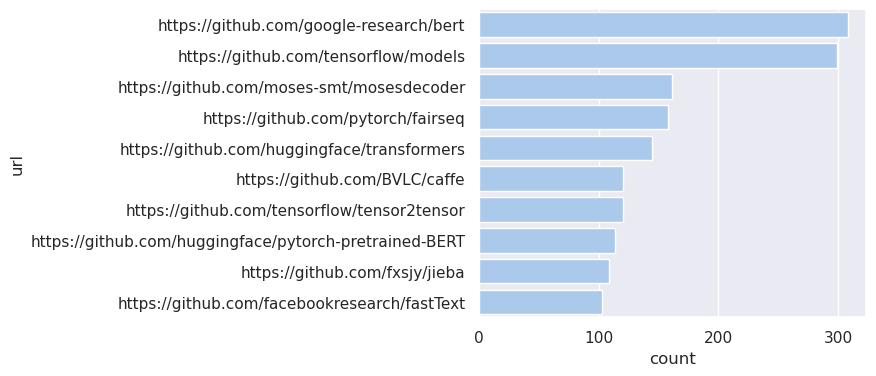

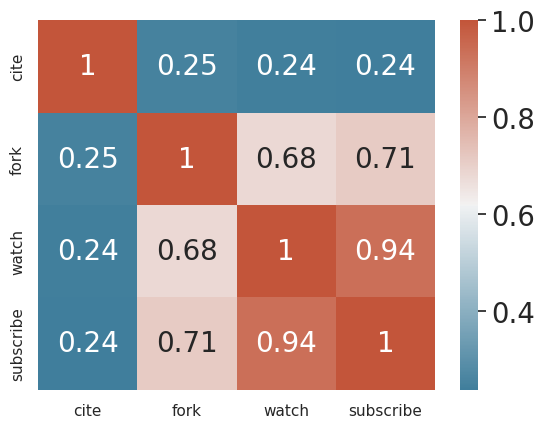

In [22]:
url_occurs_count = np.array(list(occur_count.values()))
url_occurs_count_biggereq_2 = np.array([e for e in url_occurs_count if e > 1])
l4 = heapq.nlargest(10, range(len(url_occurs_count)), url_occurs_count.take)
# l5 = heapq.nsmallest(30, range(len(url_occurs_count)), url_occurs_count.take)
# l4 = heapq.nlargest(30, range(len(url_occurs_count_biggereq_2)), url_occurs_count_biggereq_2.take)
l5 = heapq.nsmallest(30, range(len(url_occurs_count_biggereq_2)), url_occurs_count_biggereq_2.take)
print(df_occur_count.iloc[l4])

df4 = df_occur_count.iloc[l4]

sns.set_theme(style='whitegrid')
sns.set(font_scale=1)
sns.set_color_codes('pastel')
f, ax = plt.subplots(figsize=(5,4))


sns.barplot(
    data=df4,x='count', y='url',color='b',ax=ax
)

df_occur_count_biggereq_2 = df_occur_count[df_occur_count['count']>1]
len(df_occur_count_biggereq_2)
# print(df_occur_count_biggereq_2.iloc[l5])

merged_df = df_occur_count.merge(df_act_rec, how='inner', on='url', suffixes=(False,False))
print(len(merged_df))
#merged_df['count'] = merged_df['count']/merged_df['count'].max()
#merged_df['forks_count'] = merged_df['forks_count']/merged_df['forks_count'].max()
#merged_df['subscribers_count'] = merged_df['subscribers_count']/merged_df['subscribers_count'].max()
#merged_df['watchers_count'] = merged_df['watchers_count']/merged_df['watchers_count'].max()
merged_df.rename(columns = {'count':'cite',
                            'forks_count':'fork', 
                            'subscribers_count':'subscribe',
                            'watchers_count':'watch',
                            }, 
                         inplace = True)
print(merged_df.head())
corr = merged_df.corr()
print(corr)

import matplotlib.pyplot as plt
import seaborn as sns

# mask = np.triu(np.ones_like(corr,dtype=bool))
f,ax = plt.subplots()
cmap = sns.diverging_palette(230,20,as_cmap=True)
# sns.heatmap(corr,mask=mask,cmap=cmap,center=0.5,
#           square=True, linewidths=.1, cbar_kws={'shrink':.5})
sns.set(font_scale=1.8)
sns.heatmap(corr,cmap=cmap,annot=True,
            annot_kws={
                'fontsize': 20,}
           )

In [23]:
df_act_rec_select_min_max = df_act_rec[df_act_rec['forks_count']>40]
print(len(df_act_rec_select_min_max))
print(df_act_rec_select_min_max.head(10))

6443
                                        url  forks_count  watchers_count  \
8        https://github.com/ned14/nedmalloc           78             380   
13     https://github.com/sitaramc/gitolite         1006            8140   
23       https://github.com/bagrow/linkcomm           49              87   
29       https://github.com/clawpack/pyclaw           94             136   
39    https://github.com/ashima/webgl-noise          263            2436   
43  https://github.com/ocelma/python-recsys          443            1448   
49       https://github.com/jaberg/hyperopt          102             492   
53     https://github.com/twitter/cassovary          145            1017   
54     https://github.com/tinkerpop/gremlin          239            1931   
62     https://github.com/heartcombo/devise         5487           22889   

    subscribers_count  
8                  42  
13                385  
23                 10  
29                 26  
39                 96  
43            

In [26]:
readme_json_file = './data/readme.json.gz'
print(os.path.exists(readme_json_file))
readmes = read_repo_metadata(readme_json_file)

True


In [27]:
import re 

print(len(readmes))
cnt = 0
cnt_readme = 0
cnt_contain_urls = 0
num_urls = 0
cnt_contain_github = 0 
cnt_distinct_repo = 0
num_github = 0
github_urls_total = {}
zenodo_total = {}
doi_total = {}
distinct_repos_total = {}
fullnames = []

cnt_contain_doi = 0
cnt_contain_zenodo = 0 

def extract_owner_repo_from_github_link(github_links):
    if type(github_links) == str:
        link = github_links
        link = link.split('/')
        if link[-1] == '':
            link.pop()
        owners, repos = link[-2], link[-1]
    elif len(github_links) > 0:
        owners, repos = [], []
        for link in github_links:
            link = link.split('/')
            if link[-1] == '':
                link.pop()
            owners.append(link[-2])
            repos.append(link[-1])
    return owners, repos

def find_owner_repo(links):
    res = []
    if len(links) > 0:
        for link in links:
            link = link.split('/')
            if len(link) > 4:
                res.append("{}/{}".format(link[3], link[4]))
        res = list(set(res))
    elif type(links) == str:
        link = links
        link = link.split('/')
        return '{}/{}'.format(link[3],link[4])
    return res

for k in readmes:
    # print(k)
    md_text = readmes[k]
    # print(type(md_text))
    if type(md_text) == str:
        pass
        # print(md_text)
    if type(md_text) == dict:
        cnt_readme += 1
        # print(md_text.keys())
        fullname = md_text['fullname']
        # print(fullname)
        fullnames.append(md_text['fullname'])
        md_text = md_text['content']
        urls = re.findall(r"\b((?:https?://)(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b", md_text)
        github_urls = [e for e in urls if 'https://github' in e and fullname not in e]
        zenodo = [e for e in urls if 'zenodo' in e]
        doi = [e for e in urls if 'doi' in e]
        distinct_github_repos = find_owner_repo(github_urls)
        
        # pprint(list(set(urls)))
        # print('\n')
        if len(urls) > 0:
            cnt_contain_urls += 1
            num_urls += len(urls)
        if len(doi) > 0:
            cnt_contain_doi += 1
        if len(zenodo) > 0:
            cnt_contain_zenodo += 1
        if len(github_urls) > 0:
            cnt_contain_github += 1
            num_github += len(github_urls)
            cnt_distinct_repo += len(distinct_github_repos)
            for url in github_urls:
                if url not in github_urls_total:
                    github_urls_total[url] = 1
                else:
                    github_urls_total[url] += 1
            for repo in distinct_github_repos:
                if repo not in distinct_repos_total:
                    distinct_repos_total[repo] = 1
                else:
                    distinct_repos_total[repo] += 1
            
    cnt += 1
    if cnt > 32116:
        break
        
print('No. of README containing at least one url link:', cnt_contain_urls) # No. of README pages containing at least one url link
print('No of repo having a README:', cnt_readme) # No. of repo having a README page
print(len(fullnames)) # No. of repo having a README page
print('No. of README containing at least one github link:', cnt_contain_github) # No. of README pages containing at leat one github page
print('No. of distinct repo:',cnt_distinct_repo) # 
print('No of URLs in total:',num_urls)
print('No of GitHub links in total:',num_github)
print('Average URL links per README page:', num_urls/cnt_readme)
print('Average GitHub links per README page:',num_github/cnt_readme)
print(len(github_urls_total))
print(len(distinct_repos_total))
print('No. of README containing DOI:', cnt_contain_doi)
print('No. of README containing zenodo:', cnt_contain_zenodo)

pprint(fullnames[:3])
pprint(list(distinct_repos_total.keys())[:3])

new_fullnames = [repo for repo in distinct_repos_total if repo not in fullnames]
print(len(new_fullnames))


cnt_keyword = 0
keywords = ['data', 'Data', 'dataset', 'Dataset']
for k in readmes:
    # print(k)
    md_text = readmes[k]
    # print(type(md_text))
    if type(md_text) == str:
        pass
    if type(md_text) == dict:
        # print(md_text.keys())
        fullname = md_text['fullname']
        # print(fullname)
        fullnames.append(md_text['fullname'])
        md_text = md_text['content']
        
        for word in keywords:
            if word in md_text:
                # urls = re.findall(r"\b((?:https?://)(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b", md_text)
                # github_urls = [e for e in urls if 'https://github' in e and fullname not in e]
                
                cnt_keyword += 1
                break
print('No. README containing keywords:', cnt_keyword)

32117
No. of README containing at least one url link: 24942
No of repo having a README: 28830
28830
No. of README containing at least one github link: 13604
No. of distinct repo: 38958
No of URLs in total: 301460
No of GitHub links in total: 57775
Average URL links per README page: 10.456468955948665
Average GitHub links per README page: 2.0039889004509193
37125
25345
No. of README containing DOI: 2184
No. of README containing zenodo: 733
['JUrban/MPTP2', 'pprett/bolt', 'bmeurer/ocamljit2']
['joshsh/extendo', 'coq-community/corn', 'coq/bignums']
19861
No. README containing keywords: 19384


In [28]:
# pprint(list(github_urls_total.keys())[20:30])
pprint(new_fullnames[25:45])

['lemire/LittleIntPacker',
 'reducedb/encoding',
 'ademakov/Oroch',
 'lemire/dictionary',
 'lemire/streamvbyte',
 'zhenjl/encoding',
 'lemire/simdcomp',
 'cruppstahl/libvbyte',
 'lemire/FrameOfReference',
 'searchivarius/PyFastPFor',
 'lintool/clueweb',
 'lemire/MaskedVByte',
 'powturbo/TurboPFor-Integer-Compression',
 'Genbox/CSharpFastPFOR',
 'lemire/FastDifferentialCoding',
 'dams/Bloomd-Client',
 'geetarista/go-bloomd',
 'kiip/bloom-python-driver',
 'majelbstoat/node-bloomd',
 'casidiablo/java-bloomd-client']


In [29]:
github_urls_total_atleast2 = {k:v for k,v in github_urls_total.items() if v>4}
print(len(github_urls_total_atleast2))

1098


In [30]:
pprint(list(github_urls_total_atleast2.keys())[60:90])

['https://github.com/szagoruyko/wide-residual-networks',
 'https://github.com/rbgirshick/fast-rcnn',
 'https://github.com/ShaoqingRen/faster_rcnn',
 'https://github.com/wnzhang/make-ipinyou-data',
 'https://github.com/mila-udem/fuel',
 'https://github.com/BVLC/caffe/tree/intel',
 'https://github.com/BVLC/caffe/tree/opencl',
 'https://github.com/BVLC/caffe/tree/windows',
 'https://github.com/pybind/pybind11',
 'https://github.com/yjxiong/temporal-segment-networks',
 'https://github.com/ambv/black',
 'https://github.com/JuliaOpt/JuMP.jl',
 'https://github.com/kaldi-asr/kaldi',
 'https://github.com/erikbern/ann-benchmarks',
 'https://github.com/nmslib/hnswlib',
 'https://github.com/karpathy/char-rnn',
 'https://github.com/psf/black',
 'https://github.com/oseledets/TT-Toolbox',
 'https://github.com/google/googletest',
 'https://github.com/kkloste/hkgrow',
 'https://github.com/clab/lstm-parser',
 'https://github.com/neubig/lamtram',
 'https://github.com/clab/dynet',
 'https://github.com/dml

In [32]:
repo_content_file = './data/content_metadata.json.gz'
print(os.path.exists(repo_content_file))
root_contents = read_repo_metadata(repo_content_file)

True


In [33]:
print(list(root_contents.keys())[:3])
print(os.listdir('.'))

['0', '1', '2']
['manual_annotation_results', 'github_metadata_stats_results', 'GitHub API retrieving metadata.ipynb', '.ipynb_checkpoints', 'LICENSE', '__pycache__', '.gitignore', 'GitHubAPI_retriever_v2.py', 'data', '.git', 'metadata_stats_analysis.py', 'README.md']


In [34]:
# pprint(root_contents['3']['fullname'])
# pprint(root_contents['3']['content'])

In [35]:
def extract_file_folder_names(d):
    res = {}
    for k in d:
        if type(d[k]) == dict:
            fullname = d[k]['fullname']
            content_meta = d[k]['content']
            for e in content_meta:
                if fullname not in res:
                    res[fullname] = [e['name']]
                else:
                    res[fullname].append(e['name'])

    return res

d_list_subtree = extract_file_folder_names(root_contents)

In [36]:
print(len(set(d_list_subtree))) # 29615
print(list(d_list_subtree.values())[:1])
filtered_fullnames = []

ind_names = ['data', 'examples', 'example', 'image', 'images'] # 7882
# ind_names = ['data'] # 4726
ind_names = ['data', 'examples', 'example',] # 6972

cnt_repo = 0 
for fullname in d_list_subtree:
    for name in d_list_subtree[fullname]:
        if name in ind_names:
            cnt_repo += 1
            filtered_fullnames.append(fullname)
            break 
print(cnt_repo)

filtered_fullnames = list(set(filtered_fullnames))
# print(len(filtered_fullnames))

29615
[['.gitignore', 'Makefile-depsrepo', 'Makefile.coqrepo', 'Makefile.corninstall', 'Makefile.install', 'Makefile.repo', 'Makefile.smallinstall', 'MizItemize.pl', 'TODO', 'apacheconf-mizar.in', 'apacheconf.in', 'article.css', 'article.js', 'c_wrapper.c', 'commit.cgi', 'coq.pm', 'coqdoc.css', 'coqfooter.in', 'coqheader.in', 'coqindexheader.in', 'corn-gitignore', 'corn-install.sh', 'corn-public-repo-description', 'corndupl.pl', 'cornlist', 'cwiki-gitdaemon.run', 'cwiki.cgi', 'dependencies.pl', 'depends', 'deps', 'devel-repo-description', 'devel', 'doc', 'duplicates.pl', 'duplicates1.pl', 'git-notes.org', 'git-notes.txt', 'git-template', 'git.pm', 'gitignore-devel', 'gitignore-public', 'gitweb', 'ikiwiki-git.pm', 'ikiwiki_notes.pl', 'index.css', 'install-corn1.sh', 'install-cornmws-full.sh', 'install-cornmws1.sh', 'install-jesse-macosx.sh', 'install-jesse.sh', 'install-mws.sh', 'install-urban.sh', 'install-urban1.sh', 'jesse-install.sh', 'miz_item_deps_bf.pl', 'mizar-ikiwiki.pm', 'miza

In [37]:
filtered_fullnames[10:20]

['Ha0Tang/GestureGAN',
 'dratasich/shsa-prolog',
 'homenc/HElib',
 'gabime/spdlog',
 'Elbria/utdsm_naacl2018',
 'avalanchesiqi/twitter-sampling',
 'izmailovpavel/flowgmm',
 'GuyHacohen/curriculum_learning',
 'dav/word2vec',
 'DifanLiu/NeuralContours']